<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [206]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clone repo (if on colab)

In [207]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

fatal: destination path 'LIDC_GDRO' already exists and is not an empty directory.
/content/LIDC_GDRO


In [208]:
# !git pull

import necessary libraries

In [209]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [210]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages, train_epochs, show_scatter

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [211]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [212]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,3
1400,2,7,3,1,0,1
1435,3,6,3,1,1,3
1066,4,4,2,1,0,1
1244,5,4,2,1,2,1


First we load in the training data

In [213]:
train_data, cv_data, test_data = getImages(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [246]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [247]:
epochs = 15
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn='ERM', num_subgroups=4, scheduler=False, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


In [216]:
test(tst_loader,model, 4)

(0.9036544850498339,
 0.9142857142857143,
 0.9722222222222222,
 0.7638888888888888,
 0.9411764705882353)

### Feature Extraction

We first save model weights (for reproducibility)

In [248]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [249]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [250]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [251]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [252]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,102,0.114284,1.092620,0.045194,0.000000,0.000000,0.00000,0.016088,0.389887,0.000000,...,0.000000,1.651865,0.057312,0.025712,1.143176,0.197014,0.801935,0,0,0
1,2467,0.392762,0.819600,0.262681,0.011485,0.001726,0.00000,0.198248,0.010976,0.000000,...,0.000000,1.496611,0.011547,0.048732,1.297555,0.000000,1.878184,2,0,0
2,922,0.224796,0.987436,0.027121,0.005536,0.043899,0.00000,0.014694,0.648383,0.006404,...,0.095103,0.520295,0.000000,0.025156,0.542037,0.153384,0.159697,0,0,0
3,1695,0.286269,0.805448,0.000000,0.000000,0.000000,0.00319,0.198416,1.092871,0.000000,...,0.000513,1.210380,0.002969,0.014584,0.389263,0.255084,0.302616,0,0,0
4,1674,0.540193,0.690309,0.177131,0.168600,0.007384,0.00000,0.000000,0.074749,0.020274,...,0.000000,0.912935,0.279651,0.042771,0.830523,1.026480,0.814130,0,0,0


We again save the data for reproducibility

In [253]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [254]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [255]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [256]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [257]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

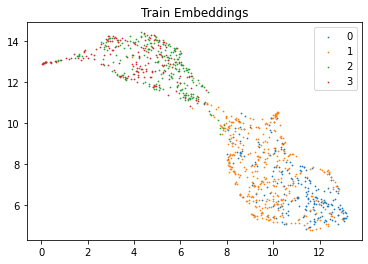

In [258]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [259]:
cv_test_embeds = reducer.transform(cv_test_features)

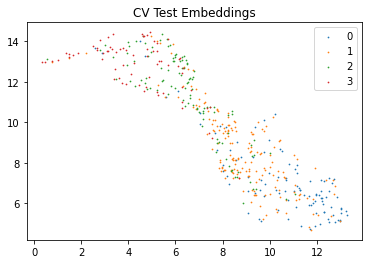

In [260]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [261]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [262]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

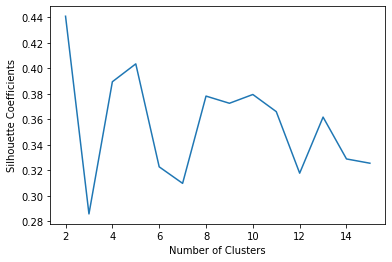

In [263]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [264]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

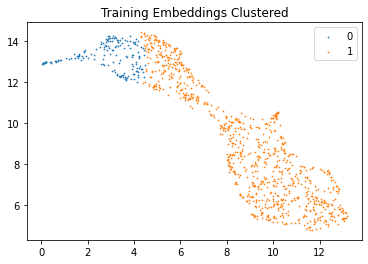

In [265]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

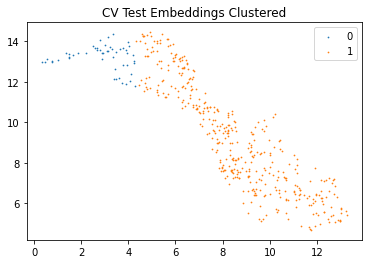

In [266]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [267]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [274]:
df_features_train['clusters'] = train_labels
df_features_cv_test['clusters'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'clusters']]
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,clusters
0,102,1
2,922,1
3,1695,1
4,1674,1
5,982,1


In [275]:
df_clusters = df_clusters.sort_values('noduleID')

We can add these lables to the df_splits dataframe

In [276]:
df_splits['clusters'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['clusters'])]

In [277]:
df_splits['clusters']

1295    1
1400    2
1435    1
1066    2
1244    2
       ..
1028    2
819     0
707     0
1436    2
501     0
Name: clusters, Length: 1488, dtype: int64

Now we save the csv

In [278]:
df_splits.to_csv('./data/LIDC_data_split.csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [279]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,1
1400,2,7,3,1,0,2
1435,3,6,3,1,1,1
1066,4,4,2,1,0,2
1244,5,4,2,1,2,2


In [280]:
train_data_c, cv_data_c, test_data_c = getImages(split=True, sublabels='clusters', binary=True, device=DEVICE)

#datasets
tr_c = SubclassedNoduleDataset(*train_data_c)
cv_c = SubclassedNoduleDataset(*cv_data_c)
tst_c = SubclassedNoduleDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=512)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

### ERM

In [281]:
model_ERM = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [282]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn='ERM', num_subgroups=3, scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15


In [283]:
test(tst_loader_c,model_ERM, 3)

(0.893687707641196, 0.9080459770114943, 1.0, 0.8181818181818182)

### GDRO

In [284]:
model_gDRO = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [285]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_gDRO, loss_fn='gDRO', num_subgroups=3, scheduler=True, verbose=True)

Epoch 1/15
Average training loss: 0.9524107098579406
Accuracy: 0.8639455782312925 
Accuracy over subgroups: [0.96875    1.         0.52777778] 
Worst Group Accuracy: 0.5277777777777778
Epoch 2/15
Average training loss: 0.43399780094623563
Accuracy: 0.7891156462585034 
Accuracy over subgroups: [0.96875    1.         0.41666667] 
Worst Group Accuracy: 0.4166666666666667
Epoch 3/15
Average training loss: 0.23592731952667237
Accuracy: 0.8299319727891157 
Accuracy over subgroups: [0.92307692 1.         0.67241379] 
Worst Group Accuracy: 0.6724137931034483
Epoch 4/15
Average training loss: 0.14469282552599907
Accuracy: 0.8435374149659864 
Accuracy over subgroups: [0.90588235 1.         0.70588235] 
Worst Group Accuracy: 0.7058823529411765
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Average training loss: 0.08740482963621617
Accuracy: 0.8571428571428571 
Accuracy over subgroups: [0.89130435 1.         0.7755102 ] 
Worst Group Accuracy: 0.7755102040816326
Epoch 6/1

In [286]:
test(tst_loader_c,model_gDRO, 3)

(0.8837209302325582, 0.92, 1.0, 0.7529411764705882)

### 20 Trials

We first write some helper functions to help display the results

In [287]:
def run_trials(runs, epochs, loss_fn):

  accuracies = []
  for run in range(runs):
    print(f'run {run+1}/{runs}')
    model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

    train_epochs(epochs, tr_loader_c, cv_loader_c, model, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=False)

    accuracies.append(test(tst_loader_c,model, 3, verbose=True))

  return accuracies

In [288]:
def plot_accuracies(all_accuracies, download_name):
  accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))
  df = pd.DataFrame(accuracies, columns = ['entire', '0', '1', '2'])

  df.to_csv(download_name)
  return df.boxplot(column=['0', '1', '2', 'entire'], figsize = (10,10)).set_ylim(0.4, 1.01)

ERM

In [289]:
accuracies_ERM = run_trials(30, 15, 'ERM')

run 1/30


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-07.
Epoch 15/15
Accuracy: 0.8737541528239202 
Accuracy over subgroups: [0.91860465 1.         0.72413793] 
Worst Group Accuracy: 0.7241379310344828
run 2/30
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Accuracy: 0.8172757475083057 
Accuracy over subgroups: [0.84699454 1.         0.689

gDRO

In [290]:
accuracies_gDRO = run_trials(30, 15, 'gDRO')

run 1/30


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 2.0000e-05.
Epoch 15/15
Accuracy: 0.8837209302325582 
Accuracy over subgroups: [0.89617486 1.         0.80722892] 
Worst Group Accuracy: 0.8072289156626506
run 2/30
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Accuracy: 0.9003322259136213 
Accuracy over subgroups: [0.9273743  1.         0.80232558] 
Worst Group Accuracy: 0.8023255813953488
run 3/30
Epoc

Now we display the accuracies

(0.4, 1.01)

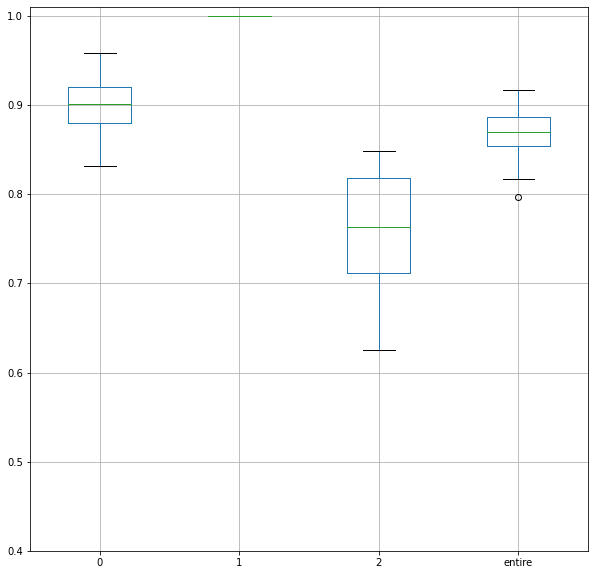

In [291]:
plot_accuracies(accuracies_ERM, './data/cluser_erm_results.csv')

(0.4, 1.01)

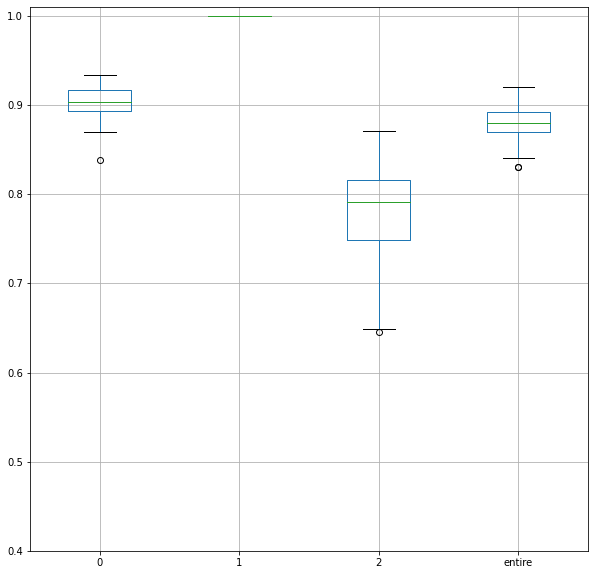

In [292]:
plot_accuracies(accuracies_gDRO, './data/cluser_gdro_results.csv')

## Now We look at what if we freeze the features trained from ERM

In [311]:
import torch.nn as nn
class NeuralNetwork(nn.Module):

    # layers = int layer sizes, starting with the input layer
    def __init__(self, *layers):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        stack = []
        for i in range(len(layers) - 1):
            stack.extend([nn.Linear(layers[i], layers[i + 1]), nn.ReLU()])

        self.linear_relu_stack = nn.Sequential(*stack[:-1])

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


### Load data

In [343]:
df = df_features.sort_values('noduleID')

In [344]:
df['clusters'] = df_splits['clusters']

In [345]:
df.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,split,malignancy,malignancy_b,clusters
337,1,3.645488,0.000000,2.332458,4.173954,3.759219,3.346448,1.130768,1.601982,3.361650,...,0.000000,1.625729,3.253064,0.155239,0.765140,0.858217,0,3,1,0
496,2,0.318794,0.631462,0.268710,0.000000,0.055971,0.024704,0.000000,0.512432,0.171651,...,0.235333,0.154671,0.068099,0.616624,1.322970,0.000000,0,3,1,0
519,3,2.509060,0.026851,2.047561,1.611777,1.163338,1.360622,0.358922,1.812587,1.973828,...,0.000000,0.246147,1.355752,0.239429,1.128834,0.387110,1,3,1,0
658,4,0.087768,1.269466,0.584058,0.000000,0.066513,0.137758,0.218069,1.877514,0.490056,...,0.187594,0.000000,0.171228,0.044957,1.414092,0.000000,0,2,1,0
726,5,0.857135,0.232343,1.426741,1.700785,0.374981,0.360183,1.409140,0.041851,0.766709,...,0.825763,0.050817,0.685377,0.322407,0.281570,0.976293,2,2,1,0


In [346]:
dfs = []
for i in range(3):
  dfs.append(df[df['split']==i])

In [347]:
datas = []
for d in dfs:
  X = torch.unbind(torch.tensor(d.drop(['noduleID','split', 'malignancy', 'malignancy_b','clusters'], axis=1).values, device=DEVICE, dtype=torch.float32))
  y = torch.unbind(torch.tensor(d['malignancy_b'].values, device=DEVICE))
  c = torch.unbind(torch.tensor(d['clusters'].values, device=DEVICE))
  datas.append((X,y,c))

In [348]:
train_data_e, cv_data_e, test_data_e = datas

#datasets
tr_e = SubclassedNoduleDataset(*train_data_e)
cv_e = SubclassedNoduleDataset(*cv_data_e)
tst_e = SubclassedNoduleDataset(*test_data_e)

#dataloaders
tr_loader_e = InfiniteDataLoader(tr_e, batch_size=512)
cv_loader_e = InfiniteDataLoader(cv_e, len(cv_e))
tst_loader_e = InfiniteDataLoader(tst_e, len(tst_e))

In [325]:
model = NeuralNetwork(512, 64, 36, 2).to(DEVICE)

### Run trials

In [349]:
def run_trials_2(runs, epochs, loss_fn):

  accuracies = []
  for run in range(runs):
    print(f'run {run+1}/{runs}')
    model = NeuralNetwork(512, 64, 36, 2).to(DEVICE)

    train_epochs(epochs, tr_loader_e, cv_loader_e, model, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=False)

    accuracies.append(test(tst_loader_e,model, 3, verbose=False))

  return accuracies

In [350]:
acc_ERM = run_trials_2(300, 15, 'ERM')

Streaming output truncated to the last 5000 lines.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-07.
Epoch 15/15
run 35/300
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
run 36/300
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 2.0000e-05.
Epoch 15/15
run 37/300
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: re

(0.4, 1.01)

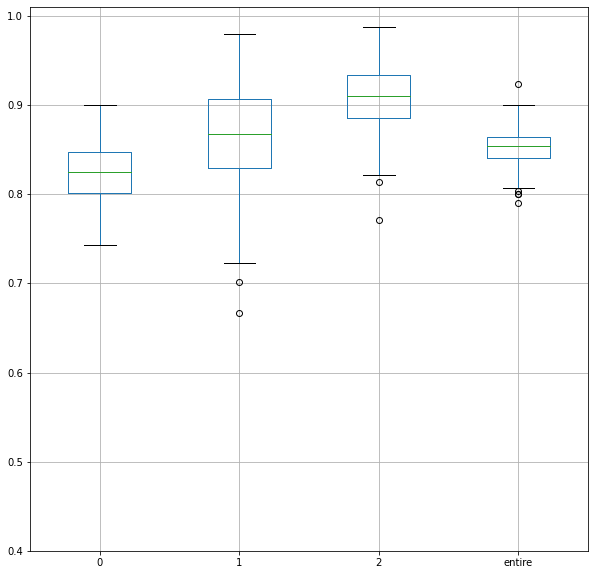

In [352]:
plot_accuracies(acc_ERM, './data/cluser_fixed_erm_results.csv')

In [ ]:
acc_GDRO = run_trials_2(300, 15, 'gDRO')

(0.4, 1.01)

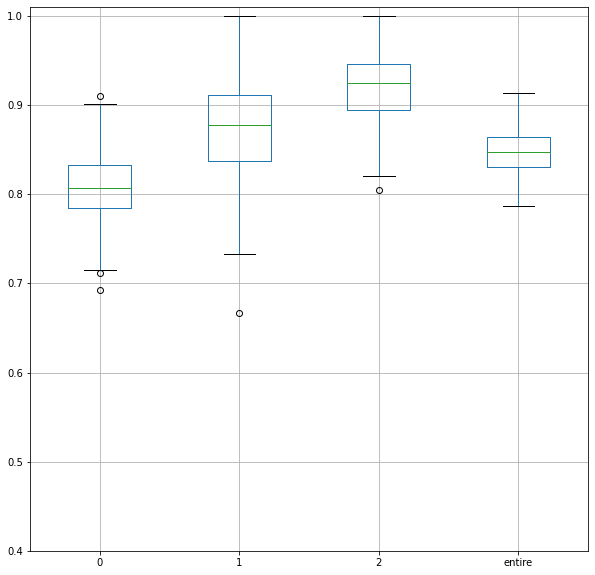

In [354]:
plot_accuracies(acc_GDRO, './data/cluser_fixed_gdro_results.csv')